# MAP 568 Project

Maxime Vincent & Swann Chelly

In [4]:
import numpy as np

from constant import *
from scipy import *
from pylab import *     
from scipy.integrate import odeint # Module de résolution des équations différentielles
import plotly as po
from progressbar import ProgressBar
import matplotlib.pyplot as plt

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [2]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : 
    
    temps : 
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    #temps = round(temps,1)
    #if temps == 50:
    #    temps = 50.1
    #elif temps > 100.:
    #    temps = 100.
    #i = time.index(temps)
    tau = cst['tau_0']*np.exp(-cst['mu']*max(temps-(cst['N']-cst['t_0']),0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-cst['lambda_1']*I_moins-(cst['gamma_IR']+cst['gamma_IH']+cst['gamma_IU'])*I_moins
    DI_plus = cst['lambda_1']*I_moins-(cst['gamma_IR']+cst['gamma_IH']+cst['gamma_IU'])*I_plus
    DR_moins = cst['gamma_IR']*I_moins-cst['lambda_2']*R_moins
    DR_plus_I = cst['gamma_IR']*I_plus+cst['lambda_2']*R_moins
    DH = cst['gamma_IH']*(I_moins + I_plus)-(cst['gamma_HR']+cst['gamma_HD']+cst['gamma_HU'])*H
    DU = cst['gamma_IU']*(I_moins + I_plus)+cst['gamma_HU']*H-(cst['gamma_UR'] + cst['gamma_UD'])*U
    DR_plus_H = cst['gamma_HR']*H+cst['gamma_UR']*U
    DD = cst['gamma_UD']*U+cst['gamma_HD']*H  
    DD_R = (cst['lambda_1']+cst['gamma_IH']+cst['gamma_IU'])*I_moins-D_R
    
    
    return(DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R)


[0.         0.00015378 0.00030749 0.00046113 0.00061471 0.0007682
 0.00092162 0.00107495 0.00122818 0.00138132 0.00153436 0.00168729
 0.00184011 0.00199281 0.00214538 0.00229783 0.00245015 0.00260232
 0.00275435 0.00290623 0.00305796 0.00320952 0.00336092 0.00351215
 0.00366319 0.00381405 0.00396473 0.0041152  0.00426548 0.00441555
 0.0045654  0.00471504 0.00486445 0.00501363 0.00516257 0.00531127
 0.00545972 0.00560792 0.00575586 0.00590352 0.00605092 0.00619804
 0.00634487 0.00649141 0.00663765 0.00678359 0.00692922 0.00707453
 0.00721952 0.00736418 0.00750851 0.0076525  0.00779614 0.00793943
 0.00808236 0.00822492 0.00836711 0.00850893 0.00865036 0.00879141
 0.00893206 0.0090723  0.00921214 0.00935157 0.00949057 0.00962915
 0.0097673  0.00990501 0.01004228 0.0101791  0.01031546 0.01045136
 0.01058679 0.01072175 0.01085624 0.01099023 0.01112374 0.01125675
 0.01138926 0.01152126 0.01165275 0.01178372 0.01191416 0.01204408
 0.01217346 0.0123023  0.01243059 0.01255833 0.01268552 0.01281

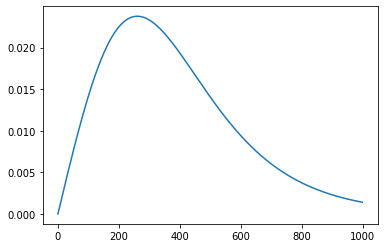

In [46]:
# Analyse des résultats

cst = init_constant()
syst_CI=array([cst['S_0'],cst['I_moins_0'],0,0,0,0,0,0,0,0])
simulation=odeint(equa_diff,syst_CI,t)
plt.plot(simulation[:,6])
print(simulation[:,6])



100% |########################################################################|


La valeur moyenne du pic est de 903.634532634414 et appartient à l'intervalle de confiance à 95% suivant : [0,1947.7] 


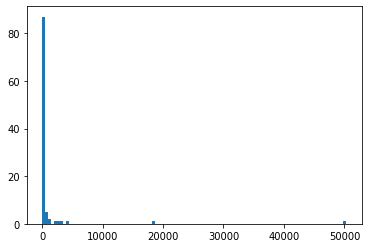

In [53]:
## Analyse des résultats par méthode de Monte Carlo. 
M = 100

def Monte_Carlo(M):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
    
    """
    
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        cst = init_constant()
        syst_CI=array([cst['S_0'],cst['I_moins_0'],0,0,0,0,0,0,0,0]) 
        simulation=odeint(equa_diff,syst_CI,t)           
        peak_value.append(np.max(simulation[:,6]))
        peak_day.append(int(np.argmax(list(simulation[:,6]))*deltaT))
        pos.append(np.max(simulation[:,2]))
        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M)
plt.hist(peak_value, bins = M)  
mean = np.mean(peak_value)
var  = np.var(peak_value)

print(f"La valeur moyenne du pic est de {mean} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean-1.96*np.sqrt(var/M),2))},{round(mean+1.96*np.sqrt(var/M),2)}] ")